<a href="https://colab.research.google.com/github/bmurmann/Ngspice-on-Colab/blob/main/notebooks/SKY130_PMOS_debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKY130 PMOS debug

# Set up dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
%%writefile environment.yml
channels:
  - litex-hub
dependencies:
  - open_pdks.sky130a
  - ngspice

Overwriting environment.yml


In [3]:
!mamba env update -n base -f environment.yml

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
[+] 0.0s
[+] 0.1s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  litex-hub/noarch                                              No change
litex-hub/linux-64                                            No change


Looking for: ['open_pdks.sky130a', 'ngspice']



  Pinned packages:

  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed

Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done
#
# To activate this environment, use
#
#     $ conda activate base
#
# To deactivate an active environment, use
#
#     $ conda deactivate



#Build tweaked BSIM4 model

In [4]:
df=pd.read_csv('https://docs.google.com/spreadsheets/d/' +
            '1Hwd8noFhY4iLRD1ox5WdAPWIZPu_natdPsb85dYDgkc' +
            '/export?gid=0&format=csv')
df

,Param,HVT_PMOS,SVT_PMOS,LVT_PMOS,SVT_PMOS_tweaked,Comments
0,NaN,BAD,VERY BAD,GOOD,NaN,NaN
1,model,xmh:sky130_fd_pr__pfe,xms:sky130_fd_pr__pfe,xml:sky130_fd_pr__pfe,my_pmos_s,NaN
2,capmod,2,2,2,2,NaN
3,diomod,1,1,1,1,NaN
4,rdsmod,0,0,0,0,NaN
...,...,...,...,...,...,...
743,vgsr_max,1.00E+99,1.00E+99,1.00E+99,1.00E+99,NaN
744,vgdr_max,1.00E+99,1.00E+99,1.00E+99,1.00E+99,NaN
745,vgbr_max,1.00E+99,1.00E+99,1.00E+99,1.00E+99,NaN
746,vbsr_max,1.00E+99,1.00E+99,1.00E+99,1.00E+99,NaN


In [5]:
f = open('tweaked_model.txt', 'w')
f.write("*Tweaked SKY130 SVT PMOS model\n")
f.write(".model tweaked_pmos pmos level=54.0 tnom=30.0\n")
for num in range(2, len(df.index)):
   f.write('+' +df.Param[num] +'=' +df.SVT_PMOS_tweaked[num] +'\n')
f.close()

In [6]:
!head tweaked_model.txt

*Tweaked SKY130 SVT PMOS model
.model tweaked_pmos pmos level=54.0 tnom=30.0
+capmod=2
+diomod=1
+rdsmod=0
+trnqsmod=0
+acnqsmod=0
+mobmod=0
+rbodymod=1
+rgatemod=0


In [7]:
!tail tweaked_model.txt

+vgd_max=1.00E+99
+vgb_max=1.00E+99
+vds_max=1.00E+99
+vbs_max=1.00E+99
+vbd_max=1.00E+99
+vgsr_max=1.00E+99
+vgdr_max=1.00E+99
+vgbr_max=1.00E+99
+vbsr_max=1.00E+99
+vbdr_max=1.00E+99


# Simulation

In [8]:
%%writefile .spiceinit
* ngspice initialization for sky130
* assert BSIM compatibility mode with "nf" vs. "W"
set ngbehavior=hsa
* "nomodcheck" speeds up loading time
set ng_nomodcheck

Writing .spiceinit


In [9]:
%%writefile netlist.spice
* PMOS VGS sweep
.lib "/usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice" tt
XMS vdp vgp 0 vbp sky130_fd_pr__pfet_01v8 L=0.15 W=2 nf=1 mult=1 m=1
+ ad='int((nf+1)/2) * W/nf * 0.29' as='int((nf+2)/2) * W/nf * 0.29'
+ pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)' nrd='0.29 / W' nrs='0.29 / W'
+ sa=0 sb=0 sd=0

.inc "tweaked_model.txt"
MS_tweak vdp vgp 0 vbp tweaked_pmos L=0.15 W=2
+as=5.8e-1 ad=5.8e-1 ps=4.58 pd=4.58 nrd=0.145 nrs=0.145

vsdp     0  vdp        dc 0.9
vsgp     0  vgp        dc 0.9
vsbp     0  vbp        dc 0
.end

.control
set wr_singlescale
save all
+ @m.XMS.msky130_fd_pr__pfet_01v8[gm] @m.XMS.msky130_fd_pr__pfet_01v8[id]
+ @MS_tweak[gm] @MS_tweak[id]
op
show
showmod m.XMS.msky130_fd_pr__pfet_01v8 MS_tweak
dc vsgp -0.5 1.8 0.01
wrdata output.txt
+ @m.XMS.msky130_fd_pr__pfet_01v8[gm] @m.XMS.msky130_fd_pr__pfet_01v8[id]
+ @MS_tweak[gm] @MS_tweak[id]
.endc

Writing netlist.spice


In [10]:
!ngspice -b netlist.spice


Note: Compatibility modes selected: hs a



Circuit: * pmos vgs sweep

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

 Reference value :  0.00000e+00
No. of Data Rows : 1
 BSIM4: Berkeley Short Channel IGFET Model-4
     device              ms_tweak
      model          tweaked_pmos
          l               1.5e-07
          w                 2e-06
          m                     1
         nf                     1
         sa                     0
         sb                     0
         sd                     0
        sca                     0
        scb                     0
        scc                     0
         sc                     0
        min                     0
         ad               5.8e-13
         as               5.8e-13
         pd              4.58e-06
         ps              4.58e-06
        nrd                 0.145
        nrs                 0.145
        off            

In [11]:
df = pd.read_csv("output.txt", delim_whitespace=True, header=None)
df.columns = ["vsg", "gm_S", "id_S", "gm_S_tweak", "id_S_tweak"]
df['gm_id_S'] = df.gm_S/df.id_S
df['gm_id_S_tweak'] = df.gm_S_tweak/df.id_S_tweak
df

,vsg,gm_S,id_S,gm_S_tweak,id_S_tweak,gm_id_S,gm_id_S_tweak
0,-0.50,2.586685e-15,9.725858e-17,5.453082e-19,2.050056e-20,26.595953,26.599671
1,-0.49,3.374672e-15,1.268910e-16,7.114804e-19,2.674772e-20,26.595049,26.599670
2,-0.48,4.402641e-15,1.655501e-16,9.282903e-19,3.489857e-20,26.594015,26.599669
3,-0.47,5.743649e-15,2.159848e-16,1.211169e-18,4.553323e-20,26.592835,26.599669
4,-0.46,7.492974e-15,2.817809e-16,1.580249e-18,5.940861e-20,26.591487,26.599668
...,...,...,...,...,...,...,...
226,1.76,3.828918e-04,3.009412e-04,3.773509e-04,2.944297e-04,1.272314,1.281633
227,1.77,3.812079e-04,3.047614e-04,3.757345e-04,2.981949e-04,1.250841,1.260030
228,1.78,3.794326e-04,3.085643e-04,3.740276e-04,3.019434e-04,1.229671,1.238734
229,1.79,3.775670e-04,3.123490e-04,3.722310e-04,3.056744e-04,1.208799,1.217737


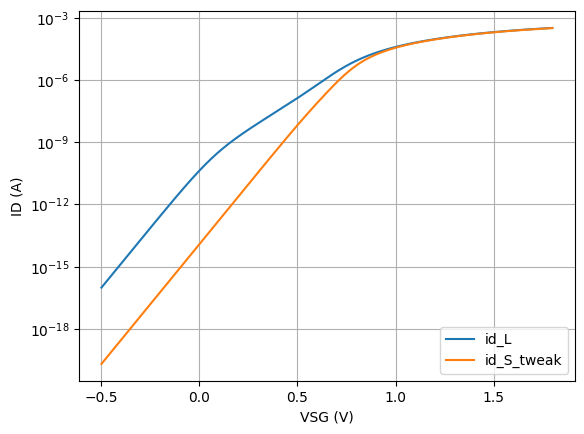

In [12]:
plt.semilogy(df.vsg, df.id_S, label="id_L")
plt.semilogy(df.vsg, df.id_S_tweak, label="id_S_tweak")
plt.xlabel("VSG (V)")
plt.ylabel("ID (A)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

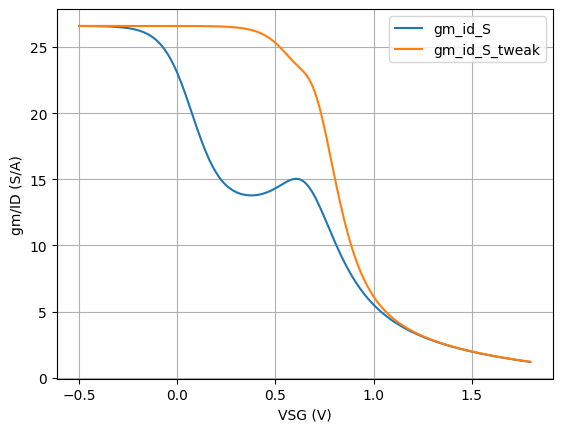

In [13]:
plt.plot(df.vsg, df.gm_id_S, label="gm_id_S")
plt.plot(df.vsg, df.gm_id_S_tweak, label="gm_id_S_tweak")
plt.xlabel("VSG (V)")
plt.ylabel("gm/ID (S/A)")
plt.legend(loc="upper right")
plt.grid()
plt.show()

In [14]:
# Overlay gm/ID from measured data
dfm=pd.read_csv('https://docs.google.com/spreadsheets/d/' +
            '1J-B1qzOxdmoTMGWhq--UArI2PJQzs_YnAjVnoVEPsGo' +
            '/export?gid=0&format=csv')
dfm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.05,NaN,NaN,16.374118,NaN,NaN,NaN,10.278328,NaN,8.716916,NaN,1.467523,16.301343,3.343010,NaN,8.674237,11.770140
2,0.10,NaN,NaN,-7.176864,NaN,NaN,NaN,10.865207,NaN,10.050428,NaN,NaN,-5.447442,-6.709838,NaN,0.871962,1.349565
3,0.15,33.901328,NaN,NaN,NaN,NaN,NaN,2.888674,NaN,-8.177886,NaN,NaN,NaN,NaN,NaN,-9.420779,1.119784
4,0.20,20.394729,NaN,NaN,NaN,NaN,11.835135,12.433692,NaN,NaN,NaN,NaN,NaN,NaN,5.851967,-83.360218,-7.727137
5,0.25,17.299221,NaN,NaN,NaN,NaN,15.273653,24.160049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.30,19.701659,NaN,NaN,16.958716,15.017078,24.401933,21.956571,15.262505,NaN,10.376185,4.445892,10.279082,19.226514,NaN,NaN,NaN
7,0.35,17.928178,16.341278,NaN,12.330729,22.037834,21.122361,21.511904,11.215359,NaN,0.197751,14.182265,15.769406,14.967587,16.150675,NaN,19.220101
8,0.40,16.375221,7.591822,16.298123,13.821589,22.361087,20.846746,19.858916,13.926177,22.788461,5.186351,23.786605,24.709783,23.582023,20.175154,17.754281,17.747086
9,0.45,16.135807,19.335843,23.831128,24.517224,22.776815,20.111855,18.122668,22.548644,24.400432,29.252895,22.526053,22.414260,21.889368,23.283854,22.704052,24.946663


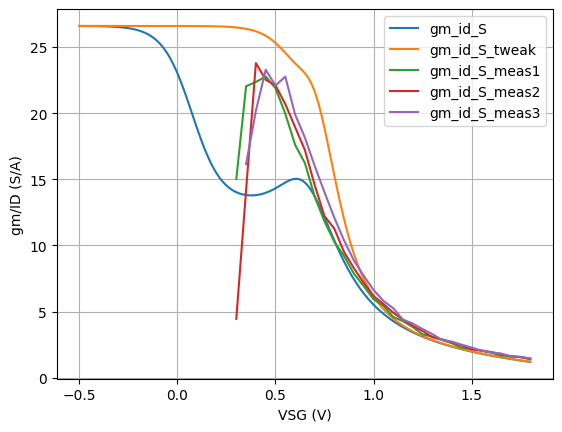

In [15]:
plt.plot(df.vsg, df.gm_id_S, label="gm_id_S")
plt.plot(df.vsg, df.gm_id_S_tweak, label="gm_id_S_tweak")
plt.plot(dfm['0'], dfm['5'], label="gm_id_S_meas1")
plt.plot(dfm['0'], dfm['11'], label="gm_id_S_meas2")
plt.plot(dfm['0'], dfm['14'], label="gm_id_S_meas3")
plt.xlabel("VSG (V)")
plt.ylabel("gm/ID (S/A)")
plt.legend(loc="upper right")
plt.grid()
plt.show()

In [46]:
# Fit using basic EKV model
UT = 1.38e-23*300/1.602e-19
n = 1.46
Vt = 0.83
q = np.logspace(-10., 2., num=100)
gm_ID_EKV = 1/n/UT/(q+1)
Vp = UT*(2*(q-1)+np.log(q))
Vg = Vt + n*Vp

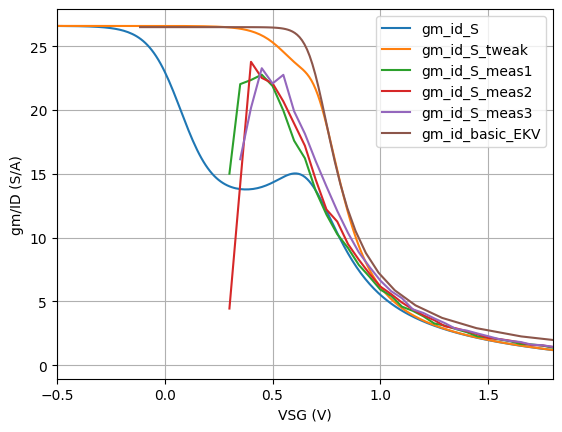

In [47]:
plt.plot(df.vsg, df.gm_id_S, label="gm_id_S")
plt.plot(df.vsg, df.gm_id_S_tweak, label="gm_id_S_tweak")
plt.plot(dfm['0'], dfm['5'], label="gm_id_S_meas1")
plt.plot(dfm['0'], dfm['11'], label="gm_id_S_meas2")
plt.plot(dfm['0'], dfm['14'], label="gm_id_S_meas3")
plt.plot(Vg, gm_ID_EKV, label="gm_id_basic_EKV")
plt.xlabel("VSG (V)")
plt.ylabel("gm/ID (S/A)")
plt.legend(loc="upper right")
plt.xlim(-0.5, 1.8)
plt.grid()
plt.show()